In [1]:
import numpy as np
import matplotlib.pyplot as plt

import flamedisx as fd

import pickle as pkl

from MatrixPlotter import shiftedColorMap
from MatrixPlotter import create_text_box
from MatrixPlotter import plottone
from MatrixPlotter import selection_data_plot

import sys
sys.path.append('../../../xlzd_reqtask_nufog')
from fogtask.fogtask import *

/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/Robert/anaconda3/envs/flamedisx/lib/python3.11/site-packages/wimprates/__init__.py:6: UserWarning: Default WIMP parameters are changed in accordance with https://arxiv.org/abs/2105.00599 (github.com/JelleAalbers/wimprates/pull/14)
  warnings.warn(


In [2]:
def hist_to_cdf(hist, ordering):
    return np.cumsum(hist.histogram.ravel()[ordering]) / hist.n

In [3]:
def ROC_2D(template_sig, template_bg):
    ratio = (template_bg + 1e-10) / (template_sig + 1e-10)
    ratio_ordering = np.argsort(ratio.histogram.ravel())

    roc = (hist_to_cdf(template_bg, ratio_ordering),
           hist_to_cdf(template_sig, ratio_ordering))

    return roc

In [4]:
def get_fixed_parameters(version='v1.1', include_varying=False):
    all_parameters = get_parameters(version=version, mode='LENR')
    analysis_parameters = all_parameters['wimp_analysis_parameters']
    
    ret_fix, ret_iter, nominal_parameters, template_format_string = get_template_parameters(version=version, mode='LENR')
    parameters = deepcopy(nominal_parameters)
    
    fixed_parameters = dict(
        cS1_min = analysis_parameters['cs1_range']['value'][0],
        cS1_max = analysis_parameters['cs1_range']['value'][-1],
        log10_cS2_min = analysis_parameters['cs2_range']['value'][0],
        log10_cS2_max = analysis_parameters['cs2_range']['value'][-1],
        s2_thr = analysis_parameters['s2_threshold']['value'],
        coin_level = analysis_parameters['coincidence_threshold']['value'],
        g1_gas = parameters['g1_gas'],
        temperature_K = parameters['temperature'],
        pressure_bar = parameters['pressure'],
        num_pmts = parameters['n_pmts'],
        double_pe_fraction = parameters['p_dpe'],
        s2Fano = parameters['s2_fano'],
        spe_res = parameters['spe_resolution'],
        spe_thr = parameters['spe_threshold'],
        spe_eff = parameters['spe_efficiency'],
        configuration = parameters['lce_configuration'])
    
    if include_varying:
        fixed_parameters['drift_field_V_cm'] = parameters['drift_field']
        fixed_parameters['gas_field_kV_cm'] = parameters['gas_field']
        fixed_parameters['g1'] = parameters['PMT_quantum_efficiency']
        fixed_parameters['elife_ns'] = parameters['electron_livetime'] * 1e6
    
    return fixed_parameters

In [5]:
def get_varying_parameters(version='v1.1', drift_field_index=0, gas_field_index=0, g1_index=0, elife_index=0):
    ret_fix, ret_iter, nominal_parameters, template_format_string = get_template_parameters(version=version, mode='LENR')
    parameters = deepcopy(ret_iter)
    
    varying_parameters = dict(
        drift_field_V_cm = parameters['drift_field'][drift_field_index],
        gas_field_kV_cm = parameters['gas_field'][gas_field_index],
        g1 = parameters['PMT_quantum_efficiency'][g1_index],
        elife_ns = parameters['electron_livetime'][elife_index] * 1e6)
    
    return varying_parameters

In [6]:
def get_roc_metric(sim_stats=int(1e6),
                   drift_field_index=0, gas_field_index=0, g1_index=0, elife_index=0):
    
    fixed_parameters = get_fixed_parameters()
    varying_parameters = get_varying_parameters(drift_field_index=drift_field_index,
                                                gas_field_index=gas_field_index,
                                                g1_index=g1_index,
                                                elife_index=elife_index)
    
    er = fd.xlzd.XLZDERSource(**fixed_parameters, **varying_parameters, energy_min=0.01, energy_max=10.)
    nr = fd.xlzd.XLZDNRSource(**fixed_parameters, **varying_parameters, energy_min=0.01, energy_max=60.)
    
    er_hist = Histdd(bins=100, range=[[fixed_parameters['cS1_min'], fixed_parameters['cS1_max']],
                                      [fixed_parameters['log10_cS2_min'], fixed_parameters['log10_cS2_max']]], axis_names=['cS1', 'log10_cS2'])
    er_data = er.simulate(sim_stats)
    er_hist.add(er_data['cs1'], np.log10(er_data['cs2']))
    er_hist.histogram = er_hist.histogram / er_hist.n

    nr_hist = Histdd(bins=100, range=[[fixed_parameters['cS1_min'], fixed_parameters['cS1_max']],
                                      [fixed_parameters['log10_cS2_min'], fixed_parameters['log10_cS2_max']]], axis_names=['cS1', 'log10_cS2'])
    nr_data = nr.simulate(sim_stats)
    nr_hist.add(nr_data['cs1'], np.log10(nr_data['cs2']))
    nr_hist.histogram = nr_hist.histogram / nr_hist.n
    
    roc = ROC_2D(nr_hist, er_hist)
    bg_at_50_sig = np.interp(0.5, xp=roc[1], fp=roc[0]) * 100 # return as %
    
    return bg_at_50_sig

In [7]:
import warnings
warnings.filterwarnings('ignore')

drift_field_values = []
gas_field_values = []
g1_values = []
elife_values = []

roc_metrics = np.zeros((5, 3, 3, 3))

for index in [0, 1, 2, 3, 4]:
    drift_field_values.append(get_varying_parameters(drift_field_index=index)['drift_field_V_cm'])
for index in [0, 1, 2]:
    gas_field_values.append(get_varying_parameters(gas_field_index=index)['gas_field_kV_cm'])
    g1_values.append(get_varying_parameters(g1_index=index)['g1'] / get_varying_parameters(g1_index=1)['g1'] * 100.)
    elife_values.append(get_varying_parameters(elife_index=index)['elife_ns'])

for drift_field_index in [0, 1, 2, 3, 4]:
    for gas_field_index in [0, 1, 2]:
        for g1_index in [0, 1, 2]:
            for elife_index in [0, 1, 2]:
                print(drift_field_index, gas_field_index, g1_index, elife_index)
                bg_at_50_sig = get_roc_metric(drift_field_index=drift_field_index, gas_field_index=gas_field_index,
                                              g1_index=g1_index, elife_index=elife_index)
                roc_metrics[drift_field_index, gas_field_index, g1_index, elife_index] = bg_at_50_sig

0 0 0 0
0 0 0 1
0 0 0 2
0 0 1 0
0 0 1 1
0 0 1 2
0 0 2 0
0 0 2 1
0 0 2 2
0 1 0 0
0 1 0 1
0 1 0 2
0 1 1 0
0 1 1 1
0 1 1 2
0 1 2 0
0 1 2 1
0 1 2 2
0 2 0 0
0 2 0 1
0 2 0 2
0 2 1 0
0 2 1 1
0 2 1 2
0 2 2 0
0 2 2 1
0 2 2 2
1 0 0 0
1 0 0 1
1 0 0 2
1 0 1 0
1 0 1 1
1 0 1 2
1 0 2 0
1 0 2 1
1 0 2 2
1 1 0 0
1 1 0 1
1 1 0 2
1 1 1 0
1 1 1 1
1 1 1 2
1 1 2 0
1 1 2 1
1 1 2 2
1 2 0 0
1 2 0 1
1 2 0 2
1 2 1 0
1 2 1 1
1 2 1 2
1 2 2 0
1 2 2 1
1 2 2 2
2 0 0 0
2 0 0 1
2 0 0 2
2 0 1 0
2 0 1 1
2 0 1 2
2 0 2 0
2 0 2 1
2 0 2 2
2 1 0 0
2 1 0 1
2 1 0 2
2 1 1 0
2 1 1 1
2 1 1 2
2 1 2 0
2 1 2 1
2 1 2 2
2 2 0 0
2 2 0 1
2 2 0 2
2 2 1 0
2 2 1 1
2 2 1 2
2 2 2 0
2 2 2 1
2 2 2 2
3 0 0 0
3 0 0 1
3 0 0 2
3 0 1 0
3 0 1 1
3 0 1 2
3 0 2 0
3 0 2 1
3 0 2 2
3 1 0 0
3 1 0 1
3 1 0 2
3 1 1 0
3 1 1 1
3 1 1 2
3 1 2 0
3 1 2 1
3 1 2 2
3 2 0 0
3 2 0 1
3 2 0 2
3 2 1 0
3 2 1 1
3 2 1 2
3 2 2 0
3 2 2 1
3 2 2 2
4 0 0 0
4 0 0 1
4 0 0 2
4 0 1 0
4 0 1 1
4 0 1 2
4 0 2 0
4 0 2 1
4 0 2 2
4 1 0 0
4 1 0 1
4 1 0 2
4 1 1 0
4 1 1 1
4 1 1 2
4 1 2 0
4 1 2 1


In [8]:
ThisColormap = plt.cm.get_cmap('viridis_r').copy()
ThisColormap.set_under('white')

formato_vertical = ["{:.0f}", "{:.0f}"]
formato_horizontal = ["{:.0f}", "{:.0f}"]

In [9]:
settings_labels = ['Drift field [V/cm]', 
                   'Gas field [kV/cm]',
                   'LCE scaling [%]' , 
                   'Electron lifetime [ms]']
settings_values = [np.flip(drift_field_values),
                   gas_field_values, 
                   g1_values, 
                   np.array(elife_values) / 1e6]

(5, 3, 3, 3)
[[80.64516129032259, 100.0, 119.35483870967742], array([ 5., 10., 50.])]
[5, 3]


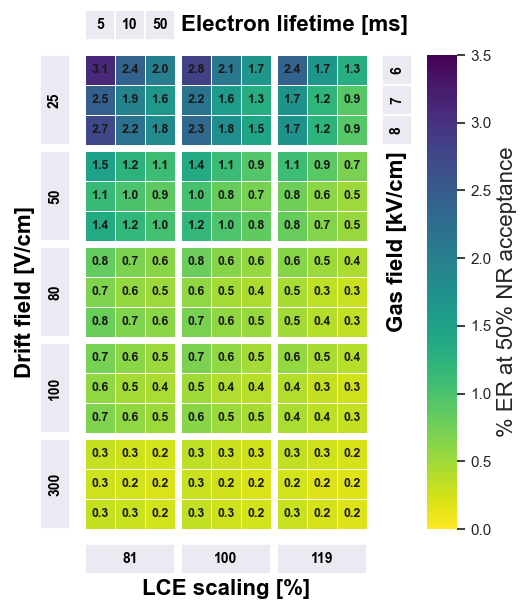

In [10]:
plottone(*selection_data_plot(roc_metrics, settings_values, settings_labels, [0, 1], [2, 3]), 
         '% ER at 50% NR acceptance', 
         scale = 0.3, fontsize = 16, annot_fontsize = 9, title = 'low_stats_scan', folder = './',
         formato_vertical=formato_vertical, formato_horizontal=formato_horizontal, cmap = ThisColormap, 
         vmin = 0, vmax = 3.5)